In [1]:
import pickle
import shap
import numpy as np
from rdkit.Chem import PandasTools, AllChem, rdFingerprintGenerator
from pandas import read_csv, DataFrame
from random import seed

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
data = read_csv('../../../DATABASE/no_missing_data.csv')
data

,molecule,smiles,max_abs,max_em,solvent,dc,etn
0,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.0,620.0,DMSO,46.8260,0.444
1,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.0,565.0,H2O,78.3553,1.000
2,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.0,575.0,AcOEt,6.0200,0.228
3,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,450.0,615.0,DCM,8.9300,0.309
4,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.0,615.0,ACN,35.6880,0.460
...,...,...,...,...,...,...,...
696,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,380.0,536.0,DCM,8.9300,0.309
697,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,374.0,549.0,ACN,37.5000,0.460
698,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,376.0,570.0,DIOX,2.2500,0.164
699,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,377.0,560.0,DCM,8.9300,0.309


In [3]:
seed(0)

np.random.seed(0)


PandasTools.AddMoleculeColumnToFrame(data, 'smiles', 'ROMol')
        # Create the fingerprint generator
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 4, fpSize = 2048)

# Generate fingerprints for each molecule
morgan_fps = [list(fp_gen.GetFingerprint(m)) for m in data['ROMol']]

morgan_df = DataFrame(morgan_fps)

morgan_df.columns = ['MF_' + str(j) for j in morgan_df.columns]
morgan_df['etn'] = data['etn'].to_numpy()
# morgan_df['max_abs'] = data['max_abs'].to_numpy()
# morgan_df['max_em'] = data['max_em'].to_numpy()
# morgan['dc'] = data['dc'].values
morgan_df

,MF_0,MF_1,MF_2,MF_3,MF_4,MF_5,MF_6,MF_7,MF_8,MF_9,...,MF_2039,MF_2040,MF_2041,MF_2042,MF_2043,MF_2044,MF_2045,MF_2046,MF_2047,etn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.444
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.228
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309
697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.460
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.164
699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309


In [4]:
seed(0)
em_model = pickle.load(open('xgb_kf_max_em.pkl', 'rb'))
abs_model = pickle.load(open('xgb_kf_max_abs.pkl', 'rb'))


In [5]:
from xgboost import XGBRegressor


model_pred = abs_model

X = morgan_df.to_numpy()
Y = data['max_abs'].to_numpy()

model_pred.fit(X, Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7202566808952925, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.069940949919729e-06,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.033074940339811634,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=502, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [6]:
from numpy import array
seed(0)
np.random.seed(0)

test_molecule_list = ['COC1=CC=CC2=NSN=C21','C1=CC2=NSN=C2C=C1', 'O=C1OC2=C(C(C)=C1)C=CC(NC(C3=C4NSN3)=CC=C4C#C[C@]56[Fe]789%10%11%12%13([C@H]5[C@@H]%11[C@@H]%12[C@@H]%136)[C@H]%14[C@@H]7[C@@H]8[C@@H]9[C@@H]%10%14)=C2','COc1c(ccc2nsnc12)c3ccccc3','COc1cc2nsnc2cc1c3ccccc3']
# 2, 1, flavio,6, 11
abs_list = [360, 310, 474,353,333]
em_list = [501, 394, 561, 533, 424]
i = 0

teste_molecules = DataFrame(test_molecule_list, columns=['smiles'])
PandasTools.AddMoleculeColumnToFrame(teste_molecules, 'smiles', 'ROMol')
morgan_test = [AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits=2048) for m in teste_molecules['ROMol']]
morgan_test = [list(i) for i in morgan_test]
morgan_test = DataFrame(morgan_test)
morgan_test.columns = ['MF_' + str(i) for i in morgan_test.columns]
morgan_test['etn'] = 0.099
morgan_test['max_abs'] = abs_list
morgan_test['max_em'] = em_list
print(morgan_test)

for i in range(len(morgan_test)):
    features = morgan_test.drop(columns=['etn', 'max_abs']).iloc[i].to_numpy().reshape(1, -1)
    y_pred = model_pred.predict(features)
    print('Smiles:', test_molecule_list[i])
    print('Expected Max em:', em_list[i])
    print('Predicted Max em:', y_pred[0])
    print('Error %:', abs(((abs_list[i] - y_pred[0])/abs_list[i])*100))
    print('\n')

   MF_0  MF_1  MF_2  MF_3  MF_4  MF_5  MF_6  MF_7  MF_8  MF_9  ...  MF_2041  \
0     0     0     0     0     0     0     0     0     0     0  ...        0   
1     0     0     0     0     0     0     0     0     0     0  ...        0   
2     0     0     0     0     0     0     0     0     0     0  ...        0   
3     0     0     0     0     0     0     0     0     0     0  ...        0   
4     0     0     0     0     0     0     0     0     0     0  ...        0   

   MF_2042  MF_2043  MF_2044  MF_2045  MF_2046  MF_2047    etn  max_abs  \
0        0        0        0        0        0        0  0.099      360   
1        0        0        0        0        0        0  0.099      310   
2        0        0        0        0        0        0  0.099      474   
3        0        0        0        0        0        0  0.099      353   
4        0        0        0        0        0        0  0.099      333   

   max_em  
0     501  
1     394  
2     561  
3     533  
4     424  

[

In [15]:
seed(0)
explainer_em = shap.Explainer(em_model)
explainer_abs = shap.Explainer(abs_model)


shap_values_em = explainer_em.shap_values(morgan_df.to_numpy())
shap_values_abs = explainer_abs.shap_values(morgan_df.to_numpy())


[12:33:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


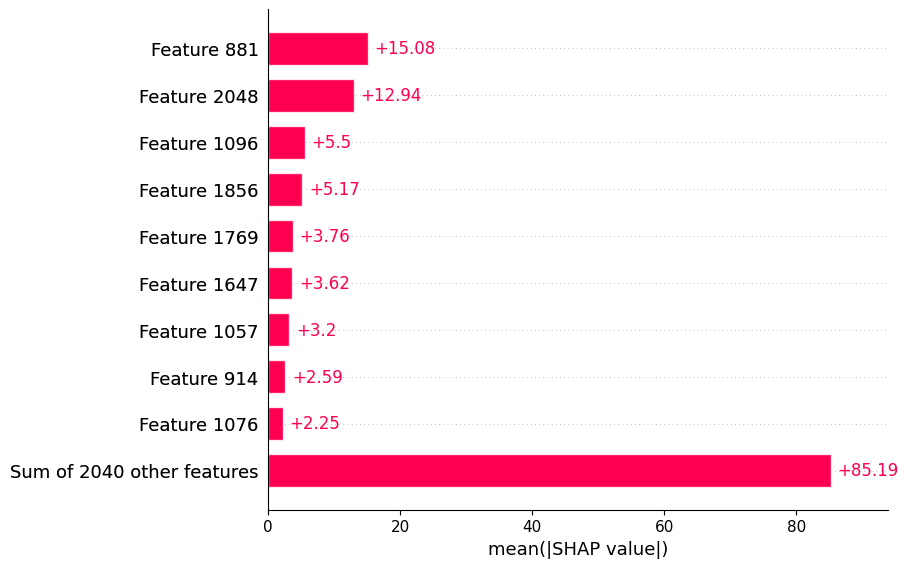

In [19]:
shap_values_em_exp = shap.Explanation(shap_values_em, data=morgan_df.to_numpy())
shap.plots.bar(shap_values_em_exp, max_display=10)


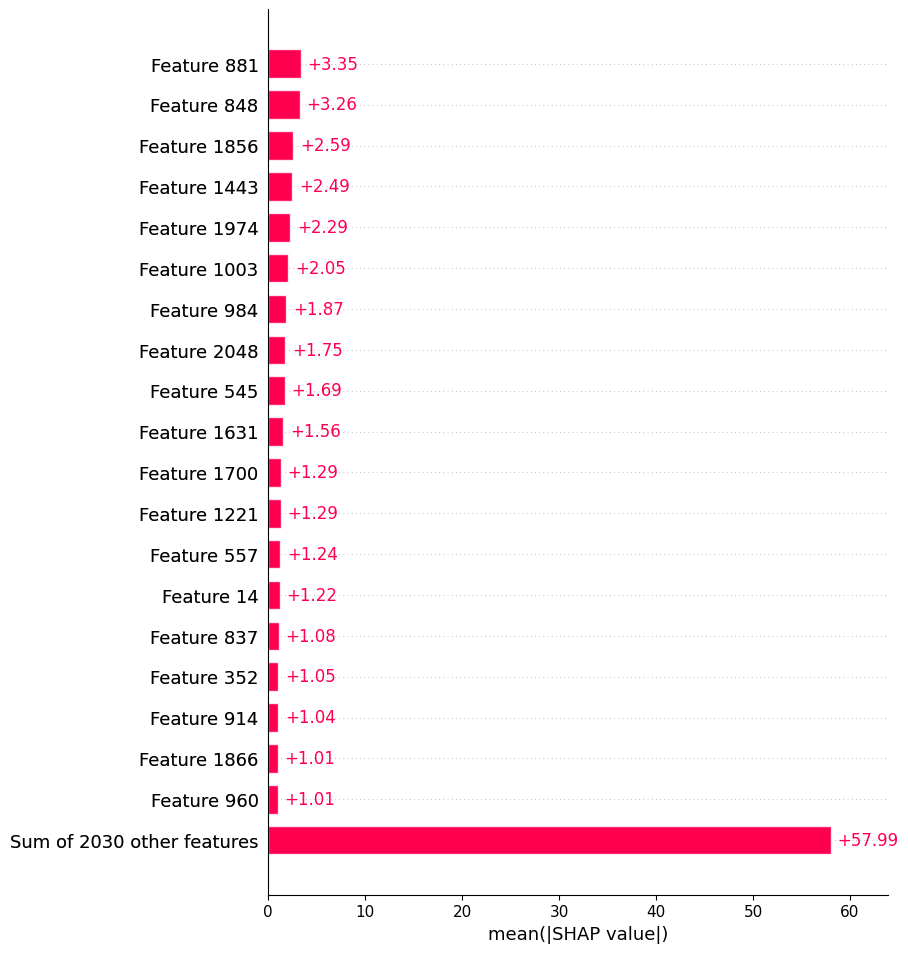

In [22]:
shap_values_em_exp = shap.Explanation(shap_values_abs, data=morgan_df.to_numpy())
shap.plots.bar(shap_values_em_exp, max_display=20)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


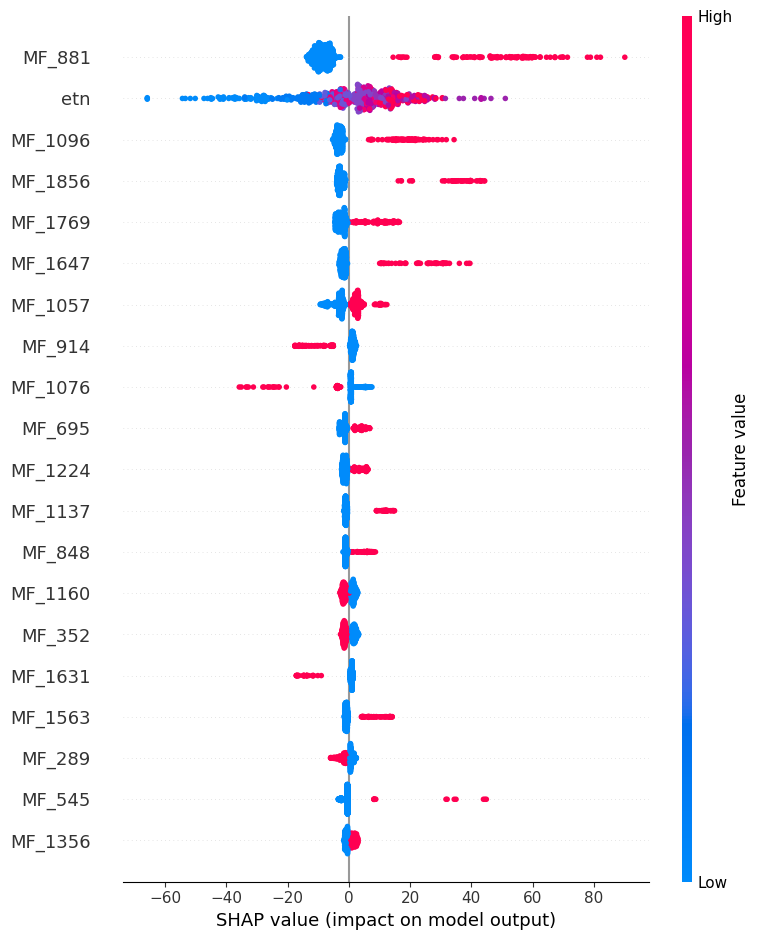

In [8]:
shap.summary_plot(shap_values_em, morgan_df, show=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


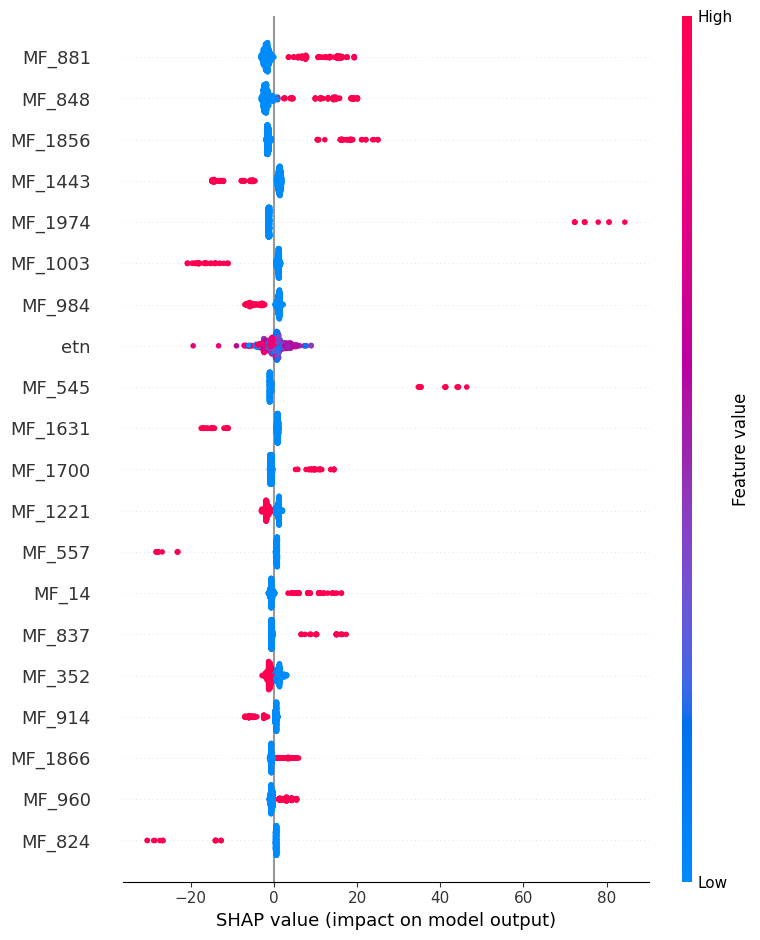

In [9]:
shap.summary_plot(shap_values_abs, morgan_df, show=False)

In [10]:
vals = np.abs(shap_values_abs).mean(0)

shap_importance = DataFrame(list(zip(morgan_df.columns, vals)), columns=['col_name', 'feature_importance_vals'])

top10_morgan = shap_importance.nlargest(12, 'feature_importance_vals')

top10_morgan = top10_morgan.drop([2048])

top10_morgan.head(10)

,col_name,feature_importance_vals
881,MF_881,3.348519
848,MF_848,3.255339
1856,MF_1856,2.591557
1443,MF_1443,2.487136
1974,MF_1974,2.294034
1003,MF_1003,2.054638
984,MF_984,1.874750
545,MF_545,1.691018
1631,MF_1631,1.555293
1700,MF_1700,1.289014


Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.


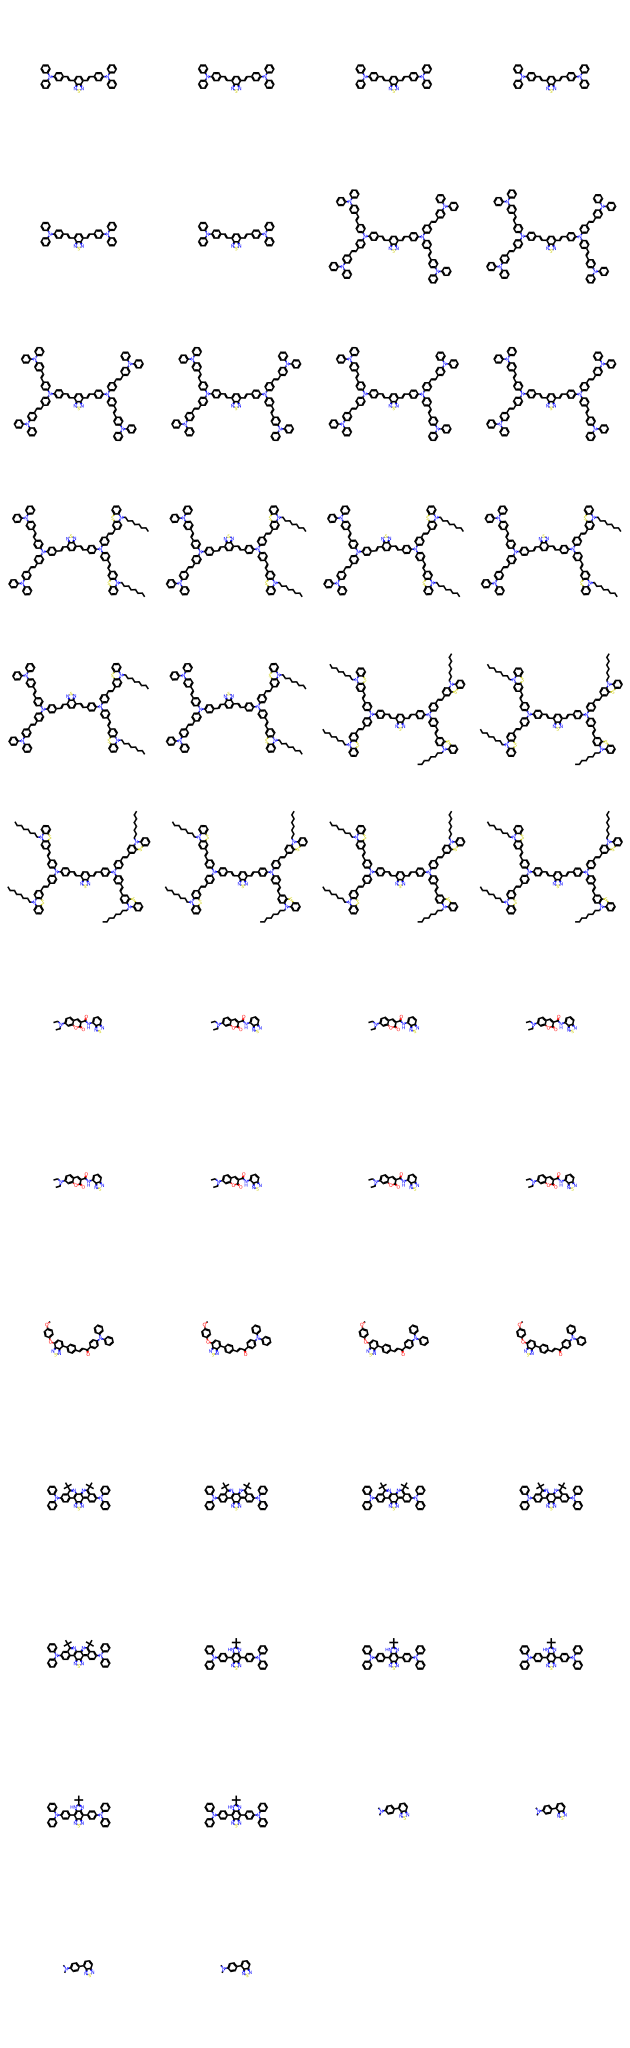

In [13]:
from rdkit.Chem import Draw

# Get the indices of molecules with the 881 bit set
molecule_indices = morgan_df[morgan_df['MF_881'] == 1].index

# Get the corresponding molecules
molecules = [data['ROMol'].iloc[i] for i in molecule_indices]

# Display the molecules
img = Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(200, 200))
img


Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


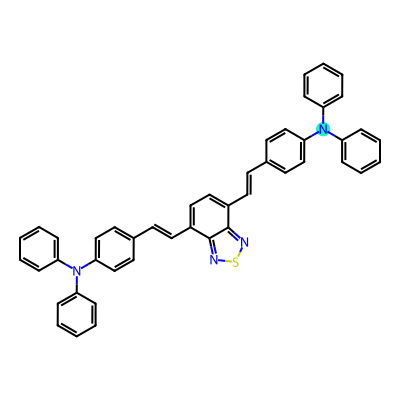

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


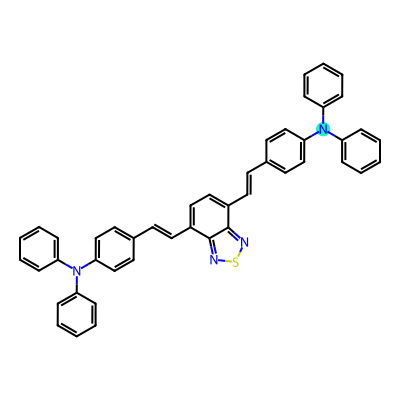

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


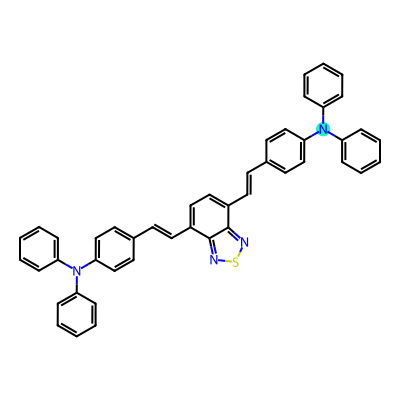

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


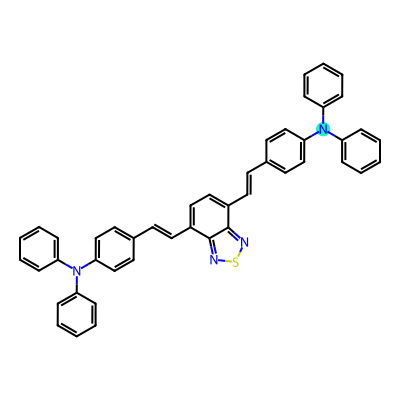

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


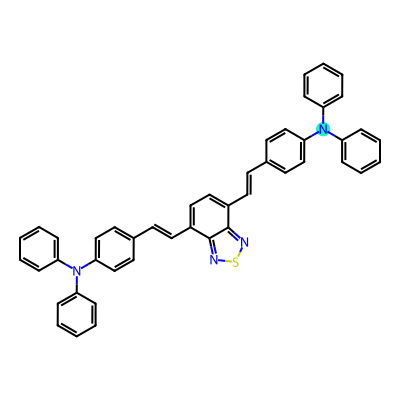

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


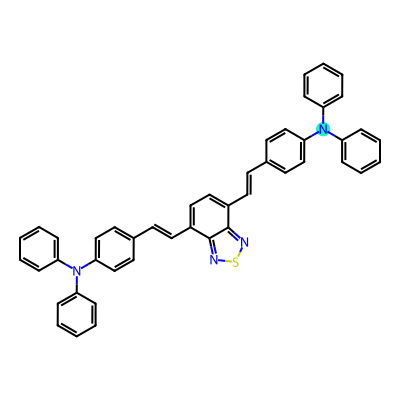

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


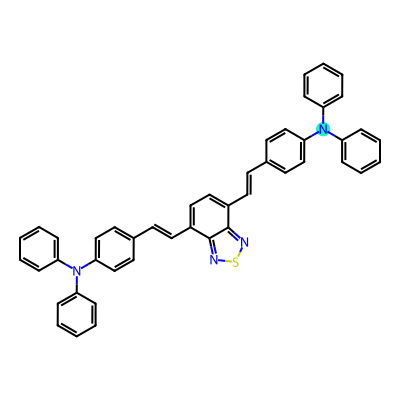

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


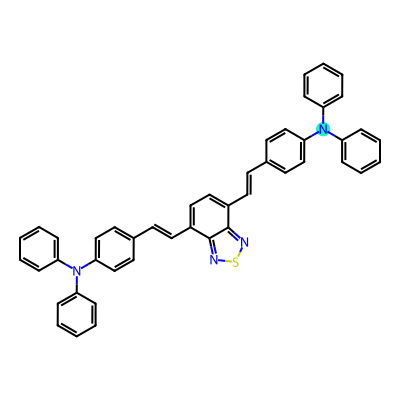

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


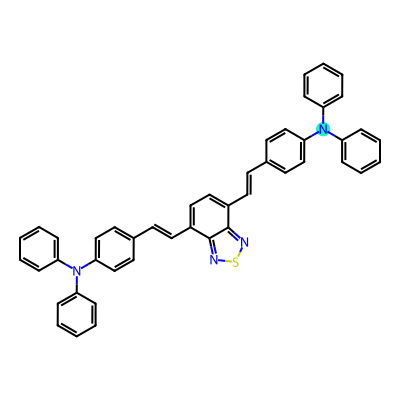

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


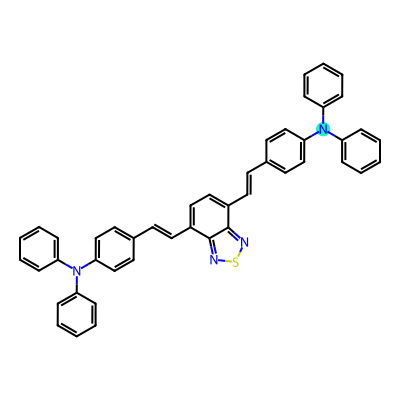

Molecule_T1
Morgan Fingerprint: 881
Smiles: C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C=CC4=CC=C(C5=NSN=C45)C=CC6=CC=C(C=C6)N(C7=CC=CC=C7)C8=CC=CC=C8


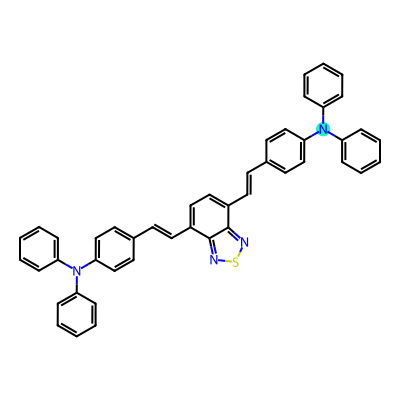

In [12]:
# from drawSmiles import *
# import cairosvg

# NamesMol = data['molecule']
# SolventMol = data['solvent']

# best_radius = 4
# best_length = 2048

# IPythonConsole.ipython_useSVG = True 

# bits = [int(x.split('_')[1]) for x in top10_morgan['col_name'] if x.startswith('MF_')]

# for j in bits:
#     bit_number = 881
#     molNumber = morgan_df.loc[morgan_df['MF_{}'.format(bit_number)] == 1].index[0]
        
#     smiles = data['smiles'].iloc[molNumber]

#     mol = Chem.MolFromSmiles(smiles)
    
#     addcords(mol)
#     info = {}

#     fp = AllChem.GetMorganFingerprintAsBitVect(mol,radius=best_radius,bitInfo=info,nBits=best_length)

#     X = draw_molecule_and_bit_info_grid(mol,info,bit_number, 400)
#     # cairosvg.svg2png(X.data, write_to='Morgan_Fingerprint_{}.png'.format(bit_number))
  
#     print('Molecule_{}'.format(NamesMol[molNumber]))
#     print('Morgan Fingerprint: {}'.format(bit_number))
#     print('Smiles: {}'.format(data['smiles'].iloc[molNumber]))  
#     display(X)